(parallel-workflows)=
# Running multiple functions in parallel

This example illustrates a workflow that triggers multiple functions in parallel. The "parent" functions run in parallel, and each parent function encapsulates multiple functions that run serially.

Use this type of workflow for anything that needs to be done in parallel. For example, data processing on multiple data sources and then combining them together.

In [1]:
import mlrun

## Create the project and the function

Create a function that prints to the logger. This is the function that will be encapsulated.

In [2]:
project = mlrun.get_or_create_project("parallel-workflow", "./", user_project=True)

> 2024-04-24 13:59:57,720 [info] Project loaded successfully: {'project_name': 'parallel-workflow'}


In [3]:
%%writefile func.py

import mlrun

# Function that prints to the logger i*100 for i that is 0-20.
def func(context):
    for i in range(5):
        context.logger.info(str(i)*100)
        
    return 1

Overwriting func.py


In [4]:
# Set the function in the project
project.set_function(
    name="func", func="func.py", image="mlrun/mlrun", kind="job", handler="func"
)

##### Run the function 

Run the function to observe the output: 5 functions running serially.

In [5]:
project.run_function("func")

> 2024-04-24 13:59:57,817 [info] Storing function: {'name': 'func-func', 'uid': 'a16de5ea293840bca48a3109b967aeee', 'db': 'http://mlrun-api:8080'}
> 2024-04-24 13:59:58,106 [info] Job is running in the background, pod: func-func-mkhbz


project,uid,iter,start,state,name,labels,inputs,parameters,results,artifacts
parallel-workflow-iguazio,...b967aeee,0,Apr 24 14:00:02,completed,func-func,v3io_user=iguaziokind=jobowner=iguaziomlrun/client_version=1.6.2-rc3mlrun/client_python_version=3.9.18host=func-func-mkhbz,,,return=1,


> 2024-04-24 14:00:11,308 [info] Run execution finished: {'status': 'completed', 'name': 'func-func'}


## Create the workflow

The `pipe_num` determines how many pipelines run in parallel in the workflow. Each pipeline creates 20 jobs that run one by one.

In this example, `pipe_num=5`, 5 pipelines in parallel. Each pipeline runs 5 jobs, 
giving a total of 5*5=25

In [6]:
%%writefile workflow.py

from kfp import dsl
from mlrun.platforms import auto_mount
import os
import sys
import mlrun

pipe_num = 5
def kfpipeline():
    with dsl.ParallelFor([i for i in range(pipe_num)]) as item:
        step_1 = mlrun.run_function('func')
        step_2 = mlrun.run_function('func').after(step_1)
        step_3 = mlrun.run_function('func').after(step_2)
        step_4 = mlrun.run_function('func').after(step_3)
        step_5 = mlrun.run_function('func').after(step_4)

Overwriting workflow.py


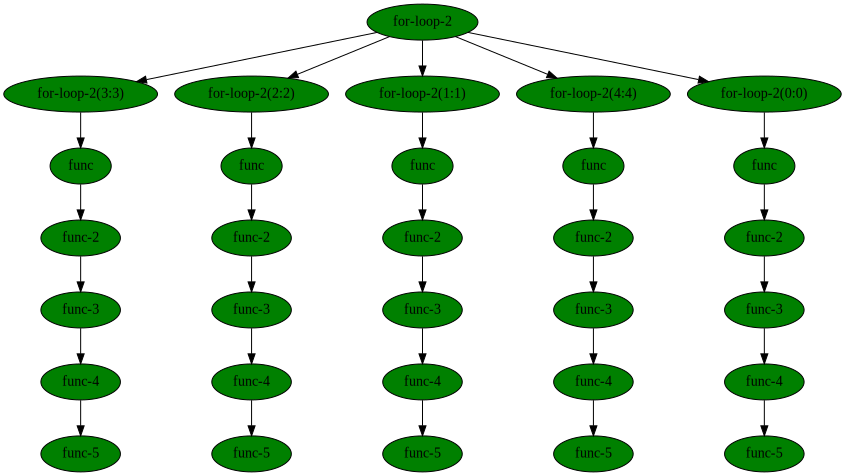

uid,start,state,name,parameters,results
...7a9479e6,Apr 24 14:04:41,completed,func,,return=1
...39a5c643,Apr 24 14:04:33,completed,func,,return=1
...3a34430e,Apr 24 14:04:26,completed,func,,return=1
...5aab88e6,Apr 24 14:04:21,completed,func,,return=1
...fba1786a,Apr 24 14:04:20,completed,func,,return=1
...a897fb17,Apr 24 14:04:01,running,func,,return=1
...84b5d054,Apr 24 14:03:45,completed,func,,return=1
...723cea8f,Apr 24 14:03:41,completed,func,,return=1
...cf053273,Apr 24 14:03:41,completed,func,,return=1
...fec48629,Apr 24 14:03:32,completed,func,,return=1


46324348-b183-4f77-b249-4952249612f7

In [7]:
project.run(workflow_path="workflow.py", watch=True)

## View the results in the UI  Monitor Workflows tab

<img src="../_static/images/parallel-workflow.png" width="800" >